In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
#turns seconds into a string format ffmpeg uses
def seconds_formatter(sec):
    x = "0" + str(datetime.timedelta(seconds=sec))[:-3]
    return x

## Random Forest Classifier
identify reaches, successes, failures

# Project Variables 
### Change as needed.

In [2]:
df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\goprolensfront-vj-2019-06-25\videos\A_copiedDeepCut_resnet50_goprolensfrontJun25shuffle1_60002.h5")
#remove extra level "scorer"
df.columns = df.columns.droplevel()


frame_rate = 119.88

total_num_frames = df.shape[0]

cols = ['Nose', 'DomInside', 'Pellet', 'Index', 'OtherHand']

classes = ['n', 's', 'f', 'r']

frames_before = 0

frames_after = 20

step_size = 1

seed = 74

In [3]:
def frame_to_time(frame):
    return round(frame/frame_rate, 3)
def time_to_frame(time):
    return int(round(time*frame_rate))

### Functions for Creating Classifier

In [4]:
import random
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

#Functions to get training data
def get_dataset(df, start_frames):
    print(df.shape)
    dataframe = df[cols]
    dataset = []
    for start_f in start_frames:
        temp_df = dataframe.iloc[start_f - frames_before: start_f + frames_after]
        if len(temp_df.values.flatten()) == 0:
            print(start_f)
            print(dataframe.shape)
        dataset.append(temp_df.values.flatten())
    return np.asarray(dataset)
def get_non_reach_frames(df, num_frames, blacklist, avoidance_radius):
    non_reaches = []
    random.seed(seed)
    while len(non_reaches) < num_frames:
        #hard code 3 non-reaches
        frame = random.randint(frames_before+10, df.shape[0] - frames_after)

        too_close = False
        for start_time in blacklist:
            if abs(frame - start_time) < avoidance_radius:
                print('no')
                too_close = True
                break
        if not too_close:
            non_reaches.append(frame)
    return non_reaches

#Use training features and labels to create Random Forest Classifier
def create_classifier(features, labels, n_trees, test_proportion=0.25):
    train_feats, test_feats, train_labs, test_labs = train_test_split(features, labels, test_size = test_proportion, random_state = seed)
    print('Training Features Shape:', train_feats.shape)
    print('Training Labels Shape:', train_labs.shape)
    print('Testing Features Shape:', test_feats.shape)
    print('Testing Labels Shape:', test_labs.shape)
    rf = RandomForestClassifier(n_estimators = n_trees, random_state = seed)
    # Train the model on training data
    print(train_feats.shape)
    print(train_labs.shape)
    rf.fit(train_feats, train_labs)
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_feats)
    print(predictions)
    print(test_labs)
    wrong_labels = []
#     for i in range(len(predictions)):
#         if predictions[i] != test_labs[i]:
#             frame = -1
#             for key in frame_to_features.keys():
#                 if (frame_to_features[key] == test_feats[i]).all():
#                     frame = key
#                     break
#             wrong_labels.append((frame_to_time(frame), predictions[i], test_labs[i]))
    for i in range(len(predictions)):
        if predictions[i] != test_labs[i]:
            frame = -1
            wrong_labels.append((predictions[i], test_labs[i]))
    print('Wrong Labels', wrong_labels)
    return rf, wrong_labels

In [11]:
reach_frames_temp, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

### Training Data

In [12]:
pm = 3
reach_frames_temp, reach_frames, reach_labels, non_reaches_frames = None, None, None, None
#"C:\Users\vjj14\Documents\GoProLens\3lens\gp2.7k3lensA1.mp4"
df_A = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\gp2.7k3lensA1DeepCut_resnet50_gopro3lensJul8shuffle1_120001.h5")
df_A.columns = df_A.columns.droplevel()
reach_times = [19.12, 23.752, 24.186, 24.630, 36.846, 43.652, 44.042, 46.964, 60.218, 62.897, 64.787, 72.045, 85.174, 88.196, 
           91.652, 93.248, 93.814, 106.294, 106.867, 111.344, 112.249, 113.407, 115.474, 115.918, 129.119, 136.837, 138.581]
reach_frames_temp = [time_to_frame(x) for x in reach_times]
reach_frames = [x - pm for x in reach_frames_temp] + reach_frames_temp[:] + [x + pm for x in reach_frames_temp]
reach_labels = ['r', 'f', 'r', 'r', 's', 'f', 's', 'r', 's', 'r', 'r', 'r', 's', 'r', 's', 'r', 'r', 'r', 'f', 'r', 'r', 
                      'r', 'f', 'r', 's', 'r', 'r']*3
non_reaches_frames = get_non_reach_frames(df_A, len(reach_frames)//2, reach_frames, 12)
featuresA = get_dataset(df_A, reach_frames+non_reaches_frames)
labelsA = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames_temp, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#"D:\DCIM\100GOPRO\2019.07.08_CC42970_N2_V3_2.7k_120FPS_Label_copy.mp4"
df_n2v3 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N2_V3_2.7k_120FPS_Label_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120001.h5")
df_n2v3.columns = df_n2v3.columns.droplevel()
reach_times = [12.325, 16.568, 17.55, 18.912, 20.41, 22.1, 22.92, 24.699, 27.4, 29.754, 30.431, 31.39, 32.692, 37.731, 
           38.258, 42.86, 45.714, 56.45, 76.803, 77.86, 86.2, 86.75, 91.13, 91.649, 97.563, 98.1, 106.739, 107.292, 116.412, 
           121.49, 122.236, 124.775, 125.375, 134.324, 134.859, 142.37, 143.0, 150.0, 159.435, 160.04, 165.02, 
           165.633, 174.018, 177.129, 179.23, 183.719, 185.755, 192.041, 197.214, 198.66, 201.286, 203.34, 204.15, 206.253, 
           209.36, 213.027, 213.895, 217.676, 218.325, 218.982, 223.198, 226.56, 230.524, 233.61, 234.286, 235.838, 236.316, 
           237.091, 250.448, 251.206, 253.05]
reach_frames_temp = [time_to_frame(x) for x in reach_times]
reach_frames = [x - pm for x in reach_frames_temp] + reach_frames_temp[:] + [x + pm for x in reach_frames_temp]

reach_labels = ['s', 'r', 'f', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'r', 'r', 's', 'r', 'f', 'r', 
                  'f', 'r', 'f', 'r', 'f', 'r', 'f', 'r', 'f', 'r', 'r', 'f', 'r', 'f', 'r', 'f', 'r', 'f', 'f', 'r', 
                  'f', 'r', 's', 'r', 's', 'f', 'r', 's', 'f', 'r', 'f', 'r', 'r', 's', 'r', 'f', 'r', 'r', 'f', 'r', 's', 
                  'r', 's', 'r', 'r', 'f', 'f', 'r', 'f', 'r', 'r']*3
non_reaches_frames = get_non_reach_frames(df_n2v3, len(reach_frames)//2, reach_frames, 12)
features_n2v3 = get_dataset(df_n2v3, reach_frames+non_reaches_frames)
labels_n2v3 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames_temp, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#"D:\DCIM\100GOPRO\2019.07.08_CC42970_N3_V3_2.7k_120FPS_Label_copy.mp4"
df_n3v3 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N3_V3_2.7k_120FPS_Label_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120001.h5")
df_n3v3.columns = df_n3v3.columns.droplevel()
reach_times = ['11.589', '17.755', '18.474', '20.810', '22.457', '25.491', '37.403', '41.884', '51.558', '57.359', 
                         '64.503', '78.54', '84.611', '96.276', '108.619', '117.017', '123.131', '130.131', '157.557', 
                         '164.342', '207.559']
reach_frames_temp = [time_to_frame(float(x)) for x in reach_times]
reach_frames = [x - pm for x in reach_frames_temp] + reach_frames_temp[:] + [x + pm for x in reach_frames_temp]
reach_labels = ['s', 'f', 'r', 'r', 'r', 's', 'f', 's', 'f', 's', 'f', 'f', 's', 'f', 's', 's', 'f', 'f', 's', 
                          's', 'f']*3
non_reaches_times = [3.333, 126.886, 133.355, 205.494, 77.901, 94.947, 26.119, 73.896, 166.391, 51.277, 5.579, 16.697, 19.257, 22.71, 28.645, 31.2]
non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
features_n3v3 = get_dataset(df_n3v3, reach_frames+non_reaches_frames)
labels_n3v3 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames_temp, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

#"D:\DCIM\100GOPRO\2019.07.08_CC42973_N2INJURED_V3_2.7k_120FPS_Label.MP4"
df_injuredn2v3 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42973_N2INJURED_V3_2.7k_120FPS_Label_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120001.h5")
df_injuredn2v3.columns = df_injuredn2v3.columns.droplevel()
reach_times = ['21.196', '66.492', '71.227', '88.349', '92.221', '99.692', '116.299', '127.703', '135.332', 
                                '142.429', '147.11', '151.609', '157.722', '163.4', '172.798', '183.103', '204.054', '208.735', '216.329']
reach_frames_temp = [time_to_frame(float(x)) for x in reach_times]
reach_frames = [x - pm for x in reach_frames_temp] + reach_frames_temp[:] + [x + pm for x in reach_frames_temp]
reach_labels = ['f', 's', 'f', 'f', 'r', 'f', 'f', 's', 'f', 'f', 's', 's', 's', 's', 'f', 'f', 'f', 'f', 's']*3
non_reaches_times = [157.463, 38.734, 62.743, 66.176, 88.856, 94.266, 171.907, 179.534, 184.588, 207.388, 72.36, 86.4, 88.5, 90.172]
non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
features_injuredn2v3 = get_dataset(df_injuredn2v3, reach_frames+non_reaches_frames)
labels_injuredn2v3 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames_temp, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

# frame_to_features

no
(17061, 27)
no
no
no
no
no
no
(30598, 27)
(25677, 27)
(26534, 27)


In [28]:
#"D:\DCIM\100GOPRO\2019.07.08_CC42973_N2INJURED_V3_2.7k_120FPS_Label.MP4"
# df_n2v2 = pd.read_hdf()
# df_n2v2.columns = df_injuredn2v3.columns.droplevel()
reach_times = ['14.711', '32.655', '42.082', '42.718', '50.958', '53.474', '54.719', '55.383', '55.788', '57.26', '58.26', 
               '62.387', '62.965', '64.111', '70.942', '77.294', '77.84', '78.877', '80.16', '81.473', '82.164', '83.054', 
               '87.903', '93.567', '94.042', '94.689', '100.837', '101.711', '102.704', '111.962', '112.742', '118.758', 
               '127.66', '128.541', '129.396', '134.4', '138.618', '139.764', '140.528', '142.385', '142.960', '143.816', 
               '145.012', '149.907', '150.44', '151.57', '152.573', '170.386', '171.026', '176.764', '177.220', '179.808', 
               '192.836', '197.232', '198.342', '198.911', '199.796']
reach_frames_temp = [time_to_frame(float(x)) for x in reach_times]
reach_frames = [x - pm for x in reach_frames_temp] + reach_frames_temp[:] + [x + pm for x in reach_frames_temp]
reach_labels = ['f', 'f', 'f', 'f', 'r', 'f', 'f', 'f', 'f', 'f', 'r', 'f', 'f', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'f', 
                     'r', 's', 'f', 'f', 'r', 'f', 'r', 'r', 'f', 'r', 'f', 'f', 'r', 'r', 's', 'r', 'r', 'r', 'f', 'f', 'r', 
                     'r', 'f', 'r', 'r', 'r', 'f', 'r', 'f', 'r', 'r', 's', 'r', 'f', 'f', 'r']*3
non_reaches_times = 
non_reaches_frames = [time_to_frame(x) for x in non_reaches_times]
features_n2v2 = get_dataset(df_n2v2, reach_frames+non_reaches_frames)
labels_n2v2 = np.asarray(reach_labels + ['n' for x in non_reaches_frames])
reach_frames_temp, reach_frames, reach_labels, non_reaches_frames = None, None, None, None

SyntaxError: can't use starred expression here (<ipython-input-28-f530a7ac9d38>, line 12)

In [21]:
x=[]
while True:
    hold = input()
    if hold == "done":
        break
    elif hold == "back":
        x.pop()
        continue
    x.append(hold)
print(x)
temp = ['14.711', '32.655', '42.082', '42.718', '50.958', '53.474', '54.719', '55.383', '55.788', '57.26', '58.26', '62.387', '62.965', '64.111', '70.942', '77.294', '77.84', '78.877', '80.16', '81.473', '82.164', '83.054', '87.903', '93.567', '94.042', '94.689', '100.837', '101.711', '102.704', '111.962', '112.742', '118.758', '127.66', '128.541', '129.396', '134.4', '138.618', '139.764', '140.528', '142.385', '142.960', '143.816', '145.012', '149.907', '150.44', '151.57', '152.573', '170.386', '171.026', '176.764', '177.220', '179.808', '192.836', '197.232', '198.342', '198.911', '199.796']
len(temp)

done
[]


57

In [27]:
y=[]
for x in temp:
    y.append(input(x))
print((len(y)))
temp1 = ['f', 'f', 'f', 'f', 'r', 'f', 'f', 'f', 'f', 'f', 'r', 'f', 'f', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'f', 'r', 's', 'f', 'f', 'r', 'f', 'r', 'r', 'f', 'r', 'f', 'f', 'r', 'r', 's', 'r', 'r', 'r', 'f', 'f', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'r', 'f', 'r', 'r', 's', 'r', 'f', 'f', 'r']
y == temp1

14.711f
32.655f
42.082f
42.718f
50.958r
53.474f
54.719f
55.383f
55.788f
57.26f
58.26r
62.387f
62.965f
64.111r
70.942r
77.294f
77.84r
78.877r
80.16r
81.473f
82.164f
83.054r
87.903s
93.567f
94.042f
94.689r
100.837f
101.711r
102.704r
111.962f
112.742r
118.758f
127.66f
128.541r
129.396r
134.4s
138.618r
139.764r
140.528r
142.385f
142.960f
143.816r
145.012r
149.907f
150.44r
151.57r
152.573r
170.386f
171.026r
176.764f
177.220r
179.808r
192.836s
197.232r
198.342f
198.911f
199.796r
57


True

In [25]:
print(y)

['f', 'f', 'f', 'f', 'r', 'f', 'f', 'f', 'f', 'f', 'r', 'f', 'f', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'f', 'r', 's', 'f', 'f', 'r', 'f', 'r', 'r', 'f', 'r', 'f', 'f', 'r', 'r', 's', 'r', 'r', 'r', 'f', 'f', 'r', 'r', 'f', 'r', 'r', 'r', 'f', 'r', 'f', 'r', 'r', 's', 'r', 'f', 'f', 'r']


# Project Variables 
### Change as needed.

In [14]:
compiled_features = np.concatenate((featuresA, features_n2v3, features_n3v3, features_injuredn2v3))
compiled_labels = np.concatenate((labelsA, labels_n2v3, labels_n3v3, labels_injuredn2v3))
print(len(compiled_features))
print(len(compiled_labels))
print(list(compiled_labels).count('r'))
print(list(compiled_labels).count('f'))
print(list(compiled_labels).count('s'))
print(list(compiled_labels).count('n'))
attempt_classifier = create_classifier(compiled_features, compiled_labels, 1000, test_proportion=0.01)[0]

590
590
180
144
90
176
Training Features Shape: (584, 300)
Training Labels Shape: (584,)
Testing Features Shape: (6, 300)
Testing Labels Shape: (6,)
(584, 300)
(584,)
['r' 'f' 's' 's' 'r' 'n']
['r' 'f' 's' 's' 'r' 'n']
Wrong Labels []


In [620]:
# wrong_ones = []
# for i in range(100, 200):
#     print(i)
#     seed = i
#     wrong_ones.extend(create_classifier(compiled_features, compiled_labels, 1000, test_proportion=0.25)[1])
# wrong_ones.sort(key= lambda x: x[0])
# wrong_df = pd.DataFrame(wrong_ones, columns = ['guess', 'actual'])
# wrong_df.groupby(wrong_df.columns.tolist(),as_index=False).size()

# Find Success, Fails, and Reaches

In [621]:
from statistics import mode, StatisticsError
#Helper Functions
def get_predicted_times(classifier, df):
    dataframe = df[cols]
    inputs = []
    num_frames = frames_before + frames_after
    for index in range(num_frames, dataframe.shape[0] - num_frames, step_size):
        temp_df = dataframe.iloc[index - frames_before: index + frames_after]
        inputs.append(temp_df.values.flatten())
    inputs = np.asarray(inputs)
    predictions = classifier.predict(inputs)
    return predictions, list(range(num_frames, dataframe.shape[0] - num_frames, step_size))
def get_starts(lst):
    def most_common(l):
        try:
            return [mode(l)]
        except StatisticsError as e:
            # will only return the first element if no unique mode found
            if 'no unique mode' in e.args[0]:
                print("TIE: ", l)
                return [l[0]]
            # this is for "StatisticsError: no mode for empty data"
            # after calling mode([])
        raise
    lst = [(frame_to_time(x[0]), x[1]) for x in lst if x[1] != 'n']
    print(lst[0])
    lst.insert(0, (-999, 'sentinel'))
    starts = []
    run = 0
    classes_list = []
    for i in range(0, len(lst)):
        run += 1
        if lst[i][1] != 'sentinel':
            classes_list.append(lst[i][1])
        if lst[i][0] - lst[i-1][0] > .2:
            starts.append((lst[i][0], most_common(classes_list), classes_list))
            classes_list = []
            run = 0
    return starts

#Find Reaches, 
def get_classified_starts(classifier, df):
    predictions2, start_frames = get_predicted_times(classifier, df)
    class_to_predictions = {}
    return get_starts(list(zip(start_frames, predictions2)))
#     for start, prediction in zip(start_frames, predictions2):
#         for c in classes:
#             if prediction == c:
#                 if c in class_to_predictions.keys():
#                     class_to_predictions[c].append(frame_to_time(start))
#                 else:
#                     class_to_predictions[c] = [frame_to_time(start)]
#     for c in classes:
#         hold = get_starts(class_to_predictions[c])
#         class_to_predictions[c] = hold
#     return class_to_predictions


In [622]:
test_df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N3_V2_2.7k_120FPS_analyze_trimDeepCut_resnet50_gopro3lensJul8shuffle1_120003.h5")
test_df.columns = test_df.columns.droplevel()
starts = get_classified_starts(attempt_classifier, test_df)
print(starts)
print(len(starts))
print([(x[0], x[2][-1]) for x in starts])
predicted_fails = [x[0] for x in starts if 'f' in x[1]]
predicted_reaches = [x[0] for x in starts if 'r' in x[1]]
predicted_successes = [x[0] for x in starts if 's' in x[1]]
print(predicted_fails)
print(predicted_reaches)
print(predicted_successes)
summ = 0
for x in starts:
    summ = summ + len(x[2])
print(summ/len(starts))

(1.969, 'r')
TIE:  ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 'r']
[(1.969, ['r'], ['r']), (2.878, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (3.829, ['r'], ['r', 'r', 'r', 'f']), (4.596, ['r'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (5.981, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']), (10.552, ['r'], ['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']), (11.028, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'r']), (15.057, ['r'], ['f', 'f', 'f', 'f', 'f', 'f', 'f',

In [623]:
test_labels = ['r', 'f', 'r', 'r', 'f', 'f', 'r', 'r', 'r', 'f', 'r', 'f', 'r', 's', 'r', 'r', 'r', 'r', 'r', 'r', 'f', 'r', 
               'r', 'r', 's', 'r', 'r', 'r', 's', 'r']
test_times = [2.08, 3.9, 4.7, 6.09, 10.66, 11.1, 15.1, 15.77, 17.9, 18.6, 19.6, 26, 28.4, 30.6, 37.2, 39.9, 41.8, 43.5, 45.7, 
              46.67, 48.4, 49, 49.25, 51.566, 52.7, 58.7, 60.5, 60.9, 64.15, 69.1]
solutions = list(zip(test_times, test_labels))
print(list(zip(test_times, test_labels)))
print(test_labels.count('f'))
print(test_labels.count('r'))
print(test_labels.count('s'))

[(2.08, 'r'), (3.9, 'f'), (4.7, 'r'), (6.09, 'r'), (10.66, 'f'), (11.1, 'f'), (15.1, 'r'), (15.77, 'r'), (17.9, 'r'), (18.6, 'f'), (19.6, 'r'), (26, 'f'), (28.4, 'r'), (30.6, 's'), (37.2, 'r'), (39.9, 'r'), (41.8, 'r'), (43.5, 'r'), (45.7, 'r'), (46.67, 'r'), (48.4, 'f'), (49, 'r'), (49.25, 'r'), (51.566, 'r'), (52.7, 's'), (58.7, 'r'), (60.5, 'r'), (60.9, 'r'), (64.15, 's'), (69.1, 'r')]
6
21
3


In [639]:
def find_differences(predicted, solutions, epsilon):
    index = 0
    while index < len(predicted) and index < len(solutions):
        diff = predicted[index][0] - solutions[index][0]
        if abs(diff) < epsilon:
            index += 1
            continue
        elif diff > 0:
            predicted.insert(index, (9999, ['x'], ['x']))
        elif diff < 0:
            solutions.insert(index, (9999, 'x'))
        index += 1
    while len(predicted) < len(solutions):
        predicted.append((9999, ['x'], ['x']))
    while len(solutions) < len(predicted):
        solutions.append((9999, 'x'))
    false_positives = [predicted[i] for i in range(len(predicted)) if solutions[i][0] == 9999]
    false_negatives = [solutions[i] for i in range(len(predicted)) if predicted[i][0] == 9999]
    print("false positives: ", false_positives, "count: ", len(false_positives))
    print("false negatives: ", false_negatives, "count: ", len(false_negatives))
    for i in range(len(predicted)-1, -1, -1):
        if predicted[i][0] == 9999 or solutions[i][0] == 9999:
            predicted.pop(i)
            solutions.pop(i)
    return (predicted, solutions)
correct_times = find_differences(starts[:], solutions[:], 0.3)
pred_label_for_correct_times = [x[1][0] for x in correct_times[0]]
true_label_for_correct_times = [x[1] for x in correct_times[1]]
print(([x[1][0] for x in correct_times[0]]))
print(([x[1] for x in correct_times[1]]))
print(len(correct_times[0]))
print()
guessed_labels = [x[1][0] for x in correct_times[0]]
true_labels = [x[1] for x in correct_times[1]]
grouped_labels = pd.DataFrame(list(zip(guessed_labels, true_labels), columns = ['guess', 'actual'])
grouped_labels.groupby(grouped_labels.columns.tolist(),as_index=False).size()

wrong_ones = [correct_times[0][i][1][0] for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
wrong_ones_correct = [correct_times[1][i][1] for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
print(wrong_ones)
print(wrong_ones_correct)
wrong_df = pd.DataFrame(list(zip(wrong_ones, wrong_ones_correct)), columns = ['guess', 'actual'])
wrong_df.groupby(wrong_df.columns.tolist(),as_index=False).size()

# wrong_ones = [(correct_times[0][i][0], correct_times[0][i][1][0]) for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
# wrong_ones_correct = [correct_times[1][i] for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]]
# print([(correct_times[0][i][0], correct_times[0][i][2]) for i in range(len(correct_times[0])) if correct_times[0][i][1][0] != correct_times[1][i][1]])
# print(list(zip(wrong_ones, wrong_ones_correct)))

SyntaxError: invalid syntax (<ipython-input-639-c515fd999aae>, line 36)

3.504 4.238


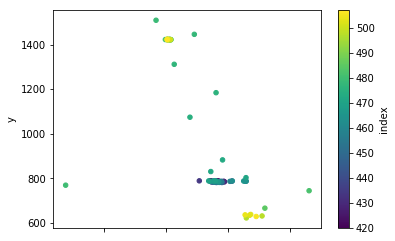

In [636]:
print(frame_to_time(420), frame_to_time(508))
test_df.iloc[420:508]['Pellet'].reset_index().plot(kind='scatter', x='x', y='y', c='index', colormap='viridis')
# plt.xticks([600, 800])

In [583]:
x = sorted(predicted_fails + predicted_reaches + predicted_successes)
print(x)
print(len(x))
import numpy as np
np.savetxt("file_name.csv", x, delimiter=",", fmt='%s', header='times')

[1.935, 2.87, 3.762, 4.588, 5.973, 10.46, 14.882, 15.616, 17.809, 18.527, 19.561, 20.913, 25.876, 26.76, 28.303, 30.547, 37.171, 38.255, 39.798, 41.725, 43.493, 45.654, 46.588, 48.365, 48.841, 51.476, 52.711, 58.634, 60.385, 60.886, 63.897, 68.093]
32


In [584]:
test_df2 = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\gopro3lens-vj-2019-07-08\videos\2019.07.08_CC42970_N2_V2_2.7k_120FPS_copyDeepCut_resnet50_gopro3lensJul8shuffle1_120001.h5")
test_df2.columns = test_df2.columns.droplevel()
starts = get_classified_starts(attempt_classifier, test_df2)
print(starts)
print(len(starts))
print([(x[0], x[2][-1]) for x in starts])
predicted_fails = [x[0] for x in starts if 'f' in x[1]]
predicted_reaches = [x[0] for x in starts if 'r' in x[1]]
predicted_successes = [x[0] for x in starts if 's' in x[1]]
print(predicted_fails)
print(predicted_reaches)
print(predicted_successes)
x = sorted(predicted_fails + predicted_reaches + predicted_successes)
print(x)
print(len(x))
import numpy as np
np.savetxt("file_name.csv", x, delimiter=",", fmt='%s', header='times')

(14.364, 'f')
TIE:  ['r', 'f']
[(14.364, ['f'], ['f']), (15.157, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']), (32.533, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']), (41.875, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f']), (42.543, ['f'], ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 's']), (50.859, ['s'

In [585]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
def create_classifierXGB(features, labels, n_trees, test_proportion=0.25):
    train_feats, test_feats, train_labs, test_labs = train_test_split(features, labels, test_size = test_proportion, random_state = seed)
    print('Training Features Shape:', train_feats.shape)
    print('Training Labels Shape:', train_labs.shape)
    print('Testing Features Shape:', test_feats.shape)
    print('Testing Labels Shape:', test_labs.shape)
    rf = xgboost.XGBClassifier()
    # Train the model on training data
    print(train_feats.shape)
    print(train_labs.shape)
    rf.fit(train_feats, train_labs)
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_feats)
    print(predictions)
    print(test_labs)
    wrong_labels = []
#     for i in range(len(predictions)):
#         if predictions[i] != test_labs[i]:
#             frame = -1
#             for key in frame_to_features.keys():
#                 if (frame_to_features[key] == test_feats[i]).all():
#                     frame = key
#                     break
#             wrong_labels.append((frame_to_time(frame), predictions[i], test_labs[i]))
    for i in range(len(predictions)):
        if predictions[i] != test_labs[i]:
            frame = -1
            wrong_labels.append((predictions[i], test_labs[i]))
    print('Wrong Labels', wrong_labels)
    return rf, wrong_labels
def create_classifierSVC(features, labels, n_trees, test_proportion=0.25):
    train_feats, test_feats, train_labs, test_labs = train_test_split(features, labels, test_size = test_proportion, random_state = seed)
    print('Training Features Shape:', train_feats.shape)
    print('Training Labels Shape:', train_labs.shape)
    print('Testing Features Shape:', test_feats.shape)
    print('Testing Labels Shape:', test_labs.shape)
    rf = svm.SVC()
    # Train the model on training data
    print(train_feats.shape)
    print(train_labs.shape)
    rf.fit(train_feats, train_labs)
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_feats)
    print(predictions)
    print(test_labs)
    wrong_labels = []
#     for i in range(len(predictions)):
#         if predictions[i] != test_labs[i]:
#             frame = -1
#             for key in frame_to_features.keys():
#                 if (frame_to_features[key] == test_feats[i]).all():
#                     frame = key
#                     break
#             wrong_labels.append((frame_to_time(frame), predictions[i], test_labs[i]))
    for i in range(len(predictions)):
        if predictions[i] != test_labs[i]:
            frame = -1
            wrong_labels.append((predictions[i], test_labs[i]))
    print('Wrong Labels', wrong_labels)
    return rf, wrong_labels
def create_classifier_tree(features, labels, n_trees, test_proportion=0.25):
    train_feats, test_feats, train_labs, test_labs = train_test_split(features, labels, test_size = test_proportion, random_state = seed)
    print('Training Features Shape:', train_feats.shape)
    print('Training Labels Shape:', train_labs.shape)
    print('Testing Features Shape:', test_feats.shape)
    print('Testing Labels Shape:', test_labs.shape)
    rf = tree.DecisionTreeClassifier()
    # Train the model on training data
    print(train_feats.shape)
    print(train_labs.shape)
    rf.fit(train_feats, train_labs)
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_feats)
    print(predictions)
    print(test_labs)
    wrong_labels = []
#     for i in range(len(predictions)):
#         if predictions[i] != test_labs[i]:
#             frame = -1
#             for key in frame_to_features.keys():
#                 if (frame_to_features[key] == test_feats[i]).all():
#                     frame = key
#                     break
#             wrong_labels.append((frame_to_time(frame), predictions[i], test_labs[i]))
    for i in range(len(predictions)):
        if predictions[i] != test_labs[i]:
            frame = -1
            wrong_labels.append((predictions[i], test_labs[i]))
    print('Wrong Labels', wrong_labels)
    return rf, wrong_labels

In [123]:
forest_classifier = create_classifier(compiled_features, compiled_labels, 1000, test_proportion=0.25)[0]

Training Features Shape: (162, 1728)
Training Labels Shape: (162,)
Testing Features Shape: (54, 1728)
Testing Labels Shape: (54,)
(162, 1728)
(162,)
['f' 's' 's' 'r' 'r' 'n' 'f' 'n' 's' 'r' 'n' 'f' 'r' 'f' 'n' 'n' 'r' 's'
 'n' 'r' 'n' 's' 'r' 'f' 'r' 'r' 'n' 'r' 's' 'r' 's' 'f' 'f' 'n' 's' 'n'
 'n' 'f' 'r' 'n' 'f' 'r' 's' 'n' 'f' 'f' 'n' 'n' 'n' 'n' 'r' 'r' 'n' 's']
['f' 's' 's' 'r' 'r' 'n' 'f' 'n' 's' 'r' 'n' 'n' 'r' 'f' 'n' 'n' 'r' 's'
 'n' 'r' 'n' 's' 'n' 'f' 'r' 'r' 'n' 'r' 's' 'r' 's' 'f' 'f' 'f' 's' 'n'
 'n' 'f' 'r' 'n' 'f' 'r' 's' 'n' 'r' 'f' 'n' 'n' 'n' 'n' 'f' 'r' 'f' 's']
Wrong Labels [('f', 'n'), ('r', 'n'), ('n', 'f'), ('f', 'r'), ('r', 'f'), ('n', 'f')]


In [121]:
XGB_classifier = create_classifierXGB(compiled_features, compiled_labels, 1000, test_proportion=0.25)[0]

Training Features Shape: (162, 1728)
Training Labels Shape: (162,)
Testing Features Shape: (54, 1728)
Testing Labels Shape: (54,)
(162, 1728)
(162,)
['f' 'f' 's' 'r' 'r' 'n' 'f' 'n' 's' 'r' 'n' 'n' 'r' 'f' 'n' 'n' 'r' 'f'
 'f' 'r' 'n' 'f' 'r' 'f' 'r' 'r' 'n' 'r' 's' 'r' 's' 'f' 'f' 'n' 's' 'n'
 'n' 'f' 'r' 'n' 'f' 'r' 's' 'n' 'f' 's' 'n' 'n' 'n' 'n' 'r' 'r' 'n' 's']
['f' 's' 's' 'r' 'r' 'n' 'f' 'n' 's' 'r' 'n' 'n' 'r' 'f' 'n' 'n' 'r' 's'
 'n' 'r' 'n' 's' 'n' 'f' 'r' 'r' 'n' 'r' 's' 'r' 's' 'f' 'f' 'f' 's' 'n'
 'n' 'f' 'r' 'n' 'f' 'r' 's' 'n' 'r' 'f' 'n' 'n' 'n' 'n' 'f' 'r' 'f' 's']
Wrong Labels [('f', 's'), ('f', 's'), ('f', 'n'), ('f', 's'), ('r', 'n'), ('n', 'f'), ('f', 'r'), ('s', 'f'), ('r', 'f'), ('n', 'f')]


C:\Users\vjj14\.conda\envs\dlc-windowsGPU\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [125]:
SVC_classifier = create_classifierSVC(compiled_features, compiled_labels, 1000, test_proportion=0.25)[0]

Training Features Shape: (162, 1728)
Training Labels Shape: (162,)
Testing Features Shape: (54, 1728)
Testing Labels Shape: (54,)
(162, 1728)
(162,)
['n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n'
 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n'
 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n']
['f' 's' 's' 'r' 'r' 'n' 'f' 'n' 's' 'r' 'n' 'n' 'r' 'f' 'n' 'n' 'r' 's'
 'n' 'r' 'n' 's' 'n' 'f' 'r' 'r' 'n' 'r' 's' 'r' 's' 'f' 'f' 'f' 's' 'n'
 'n' 'f' 'r' 'n' 'f' 'r' 's' 'n' 'r' 'f' 'n' 'n' 'n' 'n' 'f' 'r' 'f' 's']
Wrong Labels [('n', 'f'), ('n', 's'), ('n', 's'), ('n', 'r'), ('n', 'r'), ('n', 'f'), ('n', 's'), ('n', 'r'), ('n', 'r'), ('n', 'f'), ('n', 'r'), ('n', 's'), ('n', 'r'), ('n', 's'), ('n', 'f'), ('n', 'r'), ('n', 'r'), ('n', 'r'), ('n', 's'), ('n', 'r'), ('n', 's'), ('n', 'f'), ('n', 'f'), ('n', 'f'), ('n', 's'), ('n', 'f'), ('n', 'r'), ('n', 'f'), ('n', 'r'), ('n', 's'), ('n', 'r'), ('n', 'f'), ('n', 'f'), (